In [2]:
from pathlib import Path

import pandas as pd
import numpy as np

import pymc as pm
import pymc_bart as pb

import arviz as az
import matplotlib.pyplot as pp
from sklearn.preprocessing import StandardScaler

In [3]:
project_path = Path.cwd()
data_path = project_path / 'data' / '04_transformed'
df_log = pd.read_parquet(data_path/'df_log.pqt')
df = pd.read_parquet(data_path / 'df_ready4log.pqt')


In [4]:
df_log.head()

,log_rrs411,log_rrs443,log_rrs489,log_rrs510,log_rrs555,log_rrs670,log_chl,hplc_flag
index,,,,,,,,
0,-6.721774,-6.385349,-5.715930,-5.512417,-4.895630,-5.665171,3.642574,0
1,-6.847877,-6.582762,-6.131683,-5.991767,-5.484146,-6.380146,3.555634,0
2,-6.937048,-6.737605,-6.296251,-6.080199,-5.461870,-6.430107,3.292498,0
3,-6.521267,-6.353163,-5.850900,-5.609131,-4.964462,-5.734086,3.870367,0
4,-7.007475,-6.885672,-6.498347,-6.264109,-5.877890,-6.325246,3.159126,0


In [5]:
scl = StandardScaler()

In [6]:
df_log.describe()

,log_rrs411,log_rrs443,log_rrs489,log_rrs510,log_rrs555,log_rrs670,log_chl
count,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000
mean,-5.687308,-5.606181,-5.406534,-5.462662,-5.570773,-7.312502,0.205400
std,0.856911,0.742300,0.638618,0.636224,0.810560,1.355949,1.616628
min,-9.879638,-8.568312,-7.910304,-7.606344,-7.782049,-10.224216,-4.074542
25%,-6.214446,-6.058429,-5.788485,-5.843052,-6.273448,-8.515876,-1.051352
50%,-5.683984,-5.572790,-5.361253,-5.572646,-5.725533,-7.396067,0.156576
75%,-5.035964,-5.083177,-5.051478,-5.099460,-4.933532,-6.214730,1.322289
max,-3.486760,-3.589919,-3.499917,-3.414290,-3.066152,-3.586324,4.354974


In [7]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 0 to 4458
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   log_rrs411  1016 non-null   float64
 1   log_rrs443  1016 non-null   float64
 2   log_rrs489  1016 non-null   float64
 3   log_rrs510  1016 non-null   float64
 4   log_rrs555  1016 non-null   float64
 5   log_rrs670  1016 non-null   float64
 6   log_chl     1016 non-null   float64
 7   hplc_flag   1016 non-null   object 
dtypes: float64(7), object(1)
memory usage: 71.4+ KB


In [8]:
log_dx = df_log.filter(regex='log_rrs[0-9]+')
log_dy = df_log['log_chl']
bands = [i[-6:] for i in log_dx.columns]

coords = {
    'bands': bands,
    'obs_id': df_log.index}

####  Standardizing inputs

In [9]:
dx = np.exp(log_dx)
dx.rename(columns={f'{i}': f'{i[-6:]}' for i in dx.columns}, inplace=True)

In [10]:
dx_s = pd.DataFrame(scl.fit_transform(dx), columns=[f'{i}_s' for i in dx.columns])

In [11]:
dx_s.describe()

,rrs411_s,rrs443_s,rrs489_s,rrs510_s,rrs555_s,rrs670_s
count,1.016000e+03,1.016000e+03,1.016000e+03,1.016000e+03,1.016000e+03,1.016000e+03
mean,5.594825e-17,-2.797412e-17,-1.678447e-16,-1.818318e-16,-8.392237e-17,4.895472e-17
std,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00,1.000492e+00
min,-1.167581e+00,-1.270339e+00,-1.277927e+00,-1.120022e+00,-9.511413e-01,-6.432973e-01
25%,-6.781386e-01,-6.710147e-01,-6.083087e-01,-5.601719e-01,-6.718349e-01,-5.745524e-01
50%,-3.266699e-01,-2.631611e-01,-2.028126e-01,-3.503625e-01,-4.101497e-01,-4.012462e-01
75%,4.517568e-01,4.065512e-01,2.206784e-01,1.854728e-01,3.390875e-01,1.798329e-01
max,6.503488e+00,6.377472e+00,6.132714e+00,6.430065e+00,7.832434e+00,1.095391e+01


#### Band Ratio:

In [12]:
dx_br = dx.divide(dx.rrs555, axis=0)
dx_br.drop('rrs555', axis=1, inplace=True)

In [13]:
dx_br.describe()

,rrs411,rrs443,rrs489,rrs510,rrs670
count,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000
mean,1.619051,1.490941,1.466724,1.216839,0.223579
std,2.069393,1.611847,1.056824,0.531310,0.159056
min,0.055239,0.125008,0.305662,0.443422,0.023505
25%,0.397083,0.500007,0.728344,0.815873,0.102556
50%,0.797657,0.833328,1.021988,1.042698,0.180704
75%,1.541486,1.578582,1.798954,1.503744,0.301768
max,13.042209,9.608322,5.277079,3.036839,1.125106


## Modeling

#### 1. BART & Standardized data

In [14]:
with pm.Model(coords=coords) as tree_model_1:
    #Rrs_data = pm.Data('Rrs_std', dx_s, dims=['obs_id', 'bands'])
    σ = pm.Exponential("σ", 1)
    μ = pb.BART('μ', X=dx_s, Y=log_dy, m=60)
    lkl = pm.Normal('likelihood', mu=μ, sigma=σ, observed=log_dy, dims='obs_id')

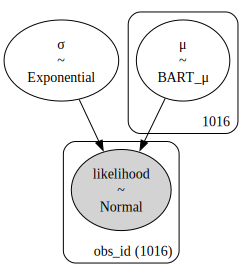

In [15]:
tree_model_1.to_graphviz()

In [16]:
with tree_model_1:
    idata = pm.sample_prior_predictive()

Sampling: [likelihood, μ, σ]


<Axes: xlabel='likelihood'>

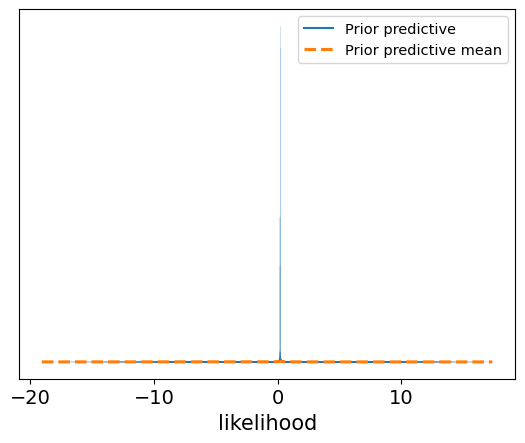

In [17]:
az.plot_ppc(idata, group='prior')

In [18]:
with tree_model_1:
    idata.extend(pm.sample(pgbart={"num_particles": 30, "batch":(0.3, 0.2)}, target_accept=0.95))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 115 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

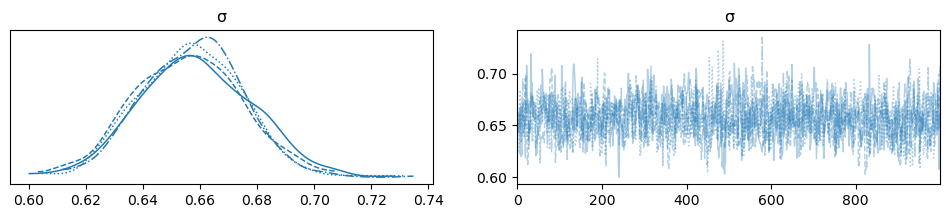

In [20]:
az.plot_trace(idata, var_names=["σ"])

In [159]:
az.summary(idata).r_hat.value_counts()

r_hat
1.00    857
1.01    160
Name: count, dtype: int64

In [ ]:
az.to_netcdf()

In [21]:
with tree_model_1:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [likelihood]


Output()

<Axes: xlabel='likelihood'>

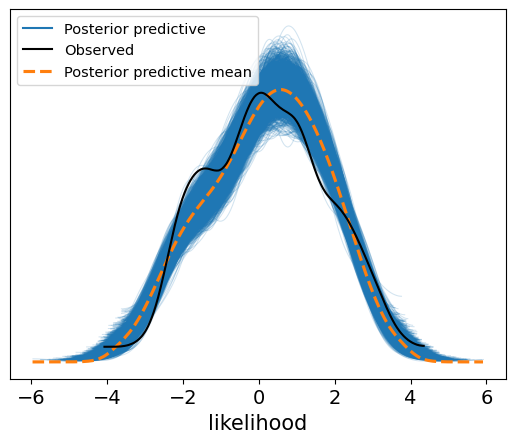

In [22]:
az.plot_ppc(idata)

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/arviz/plots/ecdfplot.py:298: BehaviourChangeWarning: In future versions, if `eval_points` is not provided, then the ECDF will be evaluated at the unique values of the sample. To keep the current behavior, provide `eval_points` explicitly.
  warnings.warn(


array([<Axes: xlabel='ESS'>, <Axes: xlabel='R-hat'>], dtype=object)

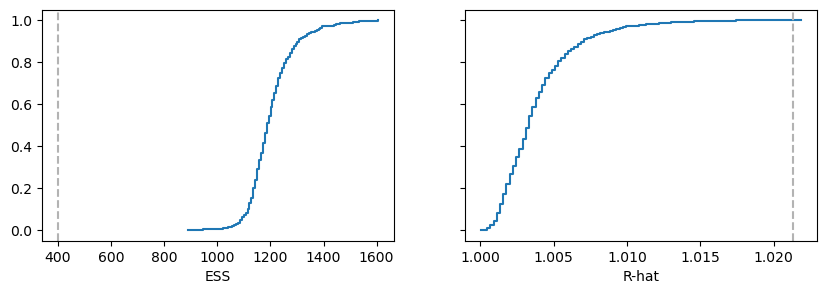

In [23]:
pb.plot_convergence(idata, var_name="μ")

In [26]:
az.summary(idata, var_names='σ')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
σ,0.657,0.018,0.624,0.691,0.001,0.0,970.0,1676.0,1.0


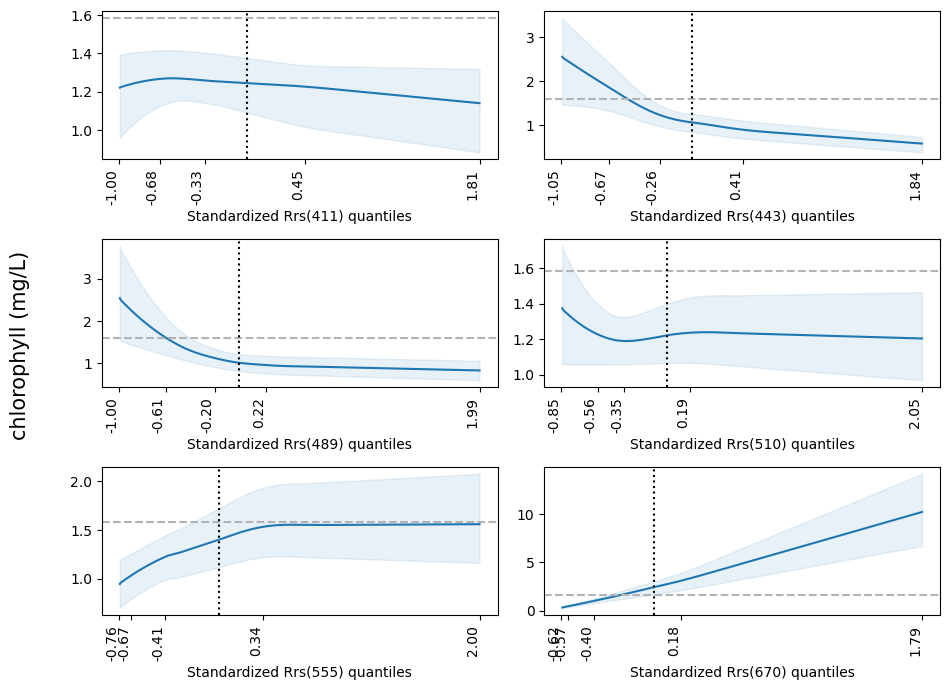

In [27]:
# Access the bartrv
bart_rv = tree_model_1.named_vars['μ']
f, axs = pp.subplots(nrows=3, ncols=2, figsize=(9, 7))
# Now you can use plot_pdp
quantiles_to_use = [0.05, 0.25, 0.5, 0.75, 0.95]
pb.plot_pdp(
    bart_rv, X=dx_s, Y=log_dy, #grid=(3, 2), figsize=(6, 8)
    func=np.exp, 
    ax=axs.flatten(), 
    xs_interval='quantiles',
    xs_values=quantiles_to_use
    )
for ax in axs.flatten():
    # Get the quantile values for the current feature
    current_feature_name = ax.get_xlabel()
    current_quantile_values = dx_s[current_feature_name].quantile(quantiles_to_use).values

    # Format Xlabels
    label = ax.get_xlabel()
    ax.set_xlabel(label.replace('rrs', 'Standardized Rrs(').replace('_s', ') quantiles'))
    # Set the x-axis ticks and labels
    ax.set_xticks(current_quantile_values)
    ax.set_xticklabels([f'{q:.2f}' for q in current_quantile_values], rotation=90, ha="right")
    ax.axvline(0, ls=':', color='k')

y_label_text = f.get_children()[-1]
y_label_text.set_text('chlorophyll (mg/L)')
f.tight_layout()

Figure X: Partial Dependence of Predicted Marine Chlorophyll a Concentration on Standardized Remote Sensing Reflectance (Rrs) at Six Wavelengths. Each subplot displays the partial dependence of the predicted chlorophyll a concentration (Chl-a, g/m³) on the standardized remote sensing reflectance (Rrs, sr⁻¹) at the indicated wavelength (411, 443, 489, 510, 555, and 670 nm). The solid line represents the mean partial dependence, and the shaded area indicates the uncertainty around these estimates. The dashed horizontal line denotes the average predicted Chl-a concentration across the entire dataset. The vertical dashed line at 0 on the x-axis indicates the mean standardized Rrs value. The plots reveal varied and non-linear relationships between reflectance at different wavelengths and predicted Chl-a, with some wavelengths showing suppressive effects (e.g., 411 nm), others exhibiting transitions across the average prediction (e.g., 443, 489 nm), and some showing primarily positive (e.g., 555, 670 nm) or negative (e.g., 510 nm) associations relative to the overall mean prediction. The approximate quantiles mentioned in the main text provide context for the standardized Rrs values on the x-axis.

### <u>Interpretation of Partial Dependence Plots</u>:
These partial dependence plots offer insights into how changes in remote sensing reflectance (Rrs) at specific wavelengths influence the predicted concentration of marine chlorophyll a (Chl-a), relative to the average prediction across all conditions.

* Rrs(411 nm): The consistent position below the reference line suggests that higher reflectance at 411 nm is generally associated with lower predicted Chl-a concentrations compared to the average. The slight initial increase up to the 25th percentile of standardized Rrs(411) (-0.68) indicates a potential minor positive influence at lower reflectance values, but beyond this point, increasing Rrs(411) strongly correlates with a decrease in predicted Chl-a.

* Rrs(443 nm): Starting above the average prediction, higher reflectance at 443 nm is linked to lower predicted Chl-a. The crossing of the reference line between the 25th and 50th percentiles of standardized Rrs(443) indicates a transition point. Below this range, higher Rrs(443) is associated with above-average Chl-a predictions, while above this range, it's associated with below-average predictions. This suggests a complex, potentially saturating relationship.

* Rrs(489 nm): The strong initial negative slope from above the reference line indicates that increasing reflectance at 489 nm is a strong predictor of lower Chl-a concentrations, particularly at lower Rrs(489) values. The crossing of the reference line just past the 25th percentile suggests that beyond this relatively low reflectance, Rrs(489) is associated with below-average Chl-a. The subsequent inflection point and reduced slope indicate a diminishing negative impact of further increases in Rrs(489).

* Rrs(510 nm): Reflectance at 510 nm consistently predicts below-average Chl-a concentrations. The initial negative slope indicates that higher Rrs(510) is associated with lower Chl-a. The inflection point around the 50th percentile marks a shift to a slight positive relationship with Chl-a, although predictions remain below average until Rrs(510) crosses the standardized mean (0). Beyond this point, the relationship flattens, suggesting that very high Rrs(510) has a minimal impact on the predicted Chl-a, albeit still generally below the overall average.

* Rrs(555 nm): Starting below the average prediction, increasing reflectance at 555 nm is associated with higher predicted Chl-a. The PDP joins the reference line around the 75th percentile of standardized Rrs(555), suggesting that beyond this relatively high reflectance, Rrs(555) has little further influence on the predicted Chl-a, remaining close to the average prediction.

* Rrs(670 nm): The consistent upward slope indicates a positive correlation between Rrs(670) and predicted Chl-a across the observed range. Starting below the average, the PDP crosses the reference line shortly after the 75th percentile, suggesting that only at relatively high Rrs(670) values are predictions above the overall average. The widening uncertainty envelope at higher Rrs(670) suggests greater model uncertainty in this range.

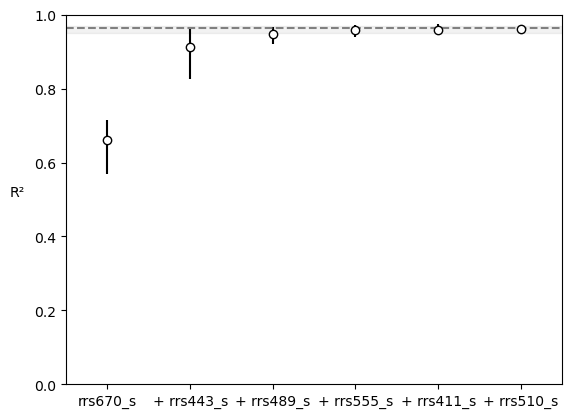

In [28]:
vi_results = pb.compute_variable_importance(idata, bartrv=bart_rv, X=dx_s)
f, ax = pp.subplots()
pb.plot_variable_importance(vi_results, ax=ax, );
#ax.set_xticklabels(ax)

#### 2. Log-transformed data

In [29]:
with pm.Model(coords=coords) as tree_model_2:
    Rrs_data = pm.Data('Rrs', log_dx, dims=['obs_id', 'bands'])
    Log_chl = pm.Data('Log_chl', log_dy, dims='obs_id')
    σ = pm.Exponential("σ", 1)
    μ = pb.BART('μ', X=Rrs_data, Y=Log_chl, m=60)
    lkl = pm.Normal('likelihood', mu=μ, sigma=σ, observed=Log_chl, dims='obs_id')

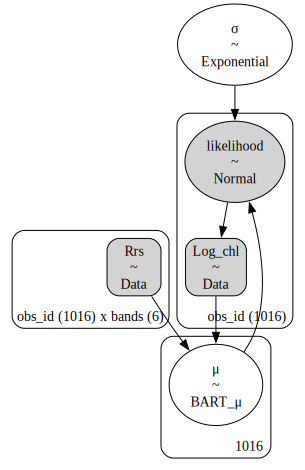

In [30]:
tree_model_2.to_graphviz()

In [31]:
with tree_model_2:
    idata2 = pm.sample_prior_predictive()

Sampling: [likelihood, μ, σ]


In [32]:
with tree_model_2:
    idata2.extend(pm.sample())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [33]:
with tree_model_2:
    idata2.extend(pm.sample_posterior_predictive(idata2))

Sampling: [likelihood]


Output()

<Axes: xlabel='likelihood'>

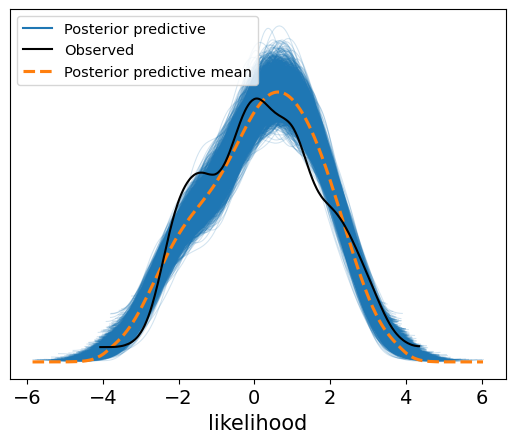

In [34]:
az.plot_ppc(idata2)

#### 3. Band Ratio Data

In [35]:
bands = [i[-6:] for i in dx_br.columns]

coords = {
    'bands': bands,
    'obs_id': df_log.index}

In [36]:
bands

['rrs411', 'rrs443', 'rrs489', 'rrs510', 'rrs670']

In [44]:
with pm.Model(coords=coords) as tree_model_3:
    Rrs_data = pm.Data('Rrs', dx_br, dims=['obs_id', 'bands'])
    Log_chl = pm.Data('Log_chl', log_dy, dims='obs_id')
    σ = pm.Exponential("σ", 1)
    μ = pb.BART('μ', X=Rrs_data, Y=Log_chl, m=60)
    lkl = pm.Normal('likelihood', mu=μ, sigma=σ, observed=Log_chl, dims='obs_id')

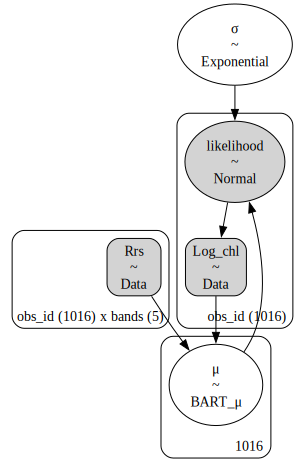

In [45]:
tree_model_3.to_graphviz()

In [46]:
with tree_model_3:
    idata3 = pm.sample_prior_predictive()
    idata3.extend(pm.sample())
    idata3.extend(pm.sample_posterior_predictive(idata3))

Sampling: [likelihood, μ, σ]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

<Axes: xlabel='likelihood'>

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


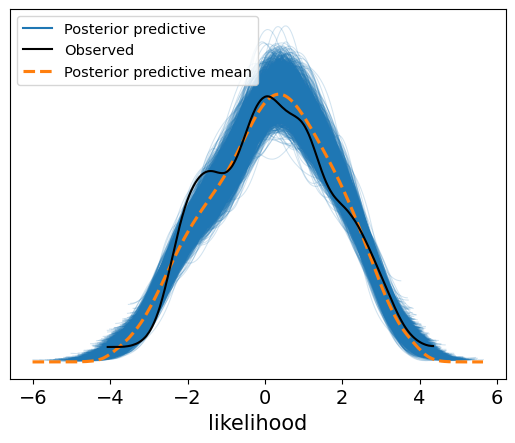

In [48]:
az.plot_ppc(idata3)

In [51]:
with tree_model_1:
  ll_tm1 =  pm.compute_log_likelihood(idata)

Output()

In [52]:
with tree_model_2:
    ll_tm2 = pm.compute_log_likelihood(idata2)

with tree_model_3:
    ll_tm3 = pm.compute_log_likelihood(idata3)

Output()

Output()

In [53]:
compare_results = az.compare(
    {'standardized' :ll_tm1, 'log(Rrs)':ll_tm2, 'band ratio':ll_tm3}, ic='loo'
)

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


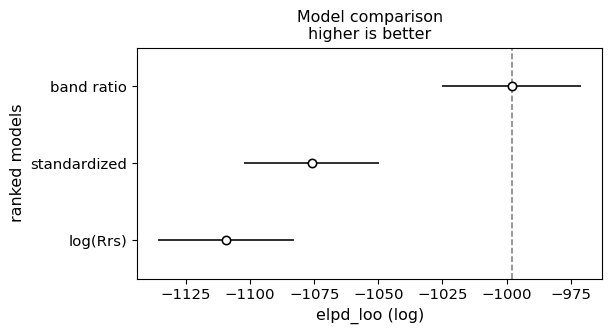

In [57]:
ax = az.plot_compare(compare_results)

### 4. Log-transformed band ratio data

In [58]:
dx_log_br = np.log(dx_br)

In [59]:
dx_log_br

,rrs411,rrs443,rrs489,rrs510,rrs670
index,,,,,
0,-1.826143,-1.489719,-0.820299,-0.616786,-0.769540
1,-1.363731,-1.098616,-0.647537,-0.507620,-0.895999
2,-1.475178,-1.275735,-0.834381,-0.618329,-0.968237
3,-1.556805,-1.388700,-0.886438,-0.644668,-0.769624
4,-1.129585,-1.007782,-0.620457,-0.386219,-0.447357
...,...,...,...,...,...
4454,-1.036393,-0.795039,-0.342940,-0.255932,-1.488418
4455,-0.367703,-0.313676,-0.122367,-0.122560,-1.648374
4456,0.037961,0.143155,0.353019,0.238488,-1.872036


In [60]:
bands = [i[-6:] for i in dx_log_br.columns]

coords = {
    'bands': bands,
    'obs_id': df_log.index}

In [61]:
with pm.Model(coords=coords) as tree_model_4:
    Rrs_data = pm.Data('Rrs', dx_log_br, dims=['obs_id', 'bands'])
    Log_chl = pm.Data('Log_chl', log_dy, dims='obs_id')
    σ = pm.Exponential("σ", 1)
    μ = pb.BART('μ', X=Rrs_data, Y=Log_chl, m=60)
    lkl = pm.Normal('likelihood', mu=μ, sigma=σ, observed=Log_chl, dims='obs_id')

In [62]:
with tree_model_4:
    idata4 = pm.sample_prior_predictive()
    idata4.extend(pm.sample())
    idata4.extend(pm.sample_posterior_predictive(idata4))

Sampling: [likelihood, μ, σ]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

In [63]:
with tree_model_4:
    ll_tm4 = pm.compute_log_likelihood(idata4)

Output()

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


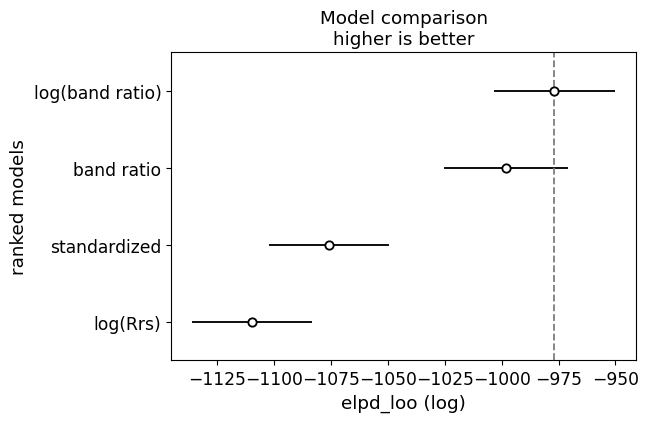

In [64]:
compare_results = az.compare(
    {'standardized' :ll_tm1, 'log(Rrs)':ll_tm2, 'band ratio':ll_tm3, 'log(band ratio)': ll_tm4}, ic='loo'
)
ax = az.plot_compare(compare_results)
fc = pp.gcf()

#### 5. OCx algorithm:

In [67]:
dx_br

,rrs411,rrs443,rrs489,rrs510,rrs670
index,,,,,
0,0.161033,0.225436,0.440300,0.539676,0.463226
1,0.255705,0.333332,0.523333,0.601926,0.408199
2,0.228738,0.279226,0.434143,0.538844,0.379752
3,0.210809,0.249399,0.412121,0.524837,0.463187
4,0.323167,0.365028,0.537699,0.679622,0.639316
...,...,...,...,...,...
4454,0.354732,0.451564,0.709681,0.774194,0.225730
4455,0.692323,0.730756,0.884823,0.884653,0.192362
4456,1.038690,1.153909,1.423358,1.269328,0.153810


In [69]:
# preprocessing:

def compute_max_ratio(row):
    # Create a dictionary of ratios for each band.
    ratios = {'443': row['rrs443'], '489': row['rrs489'], '510': row['rrs510']}
    # Identify the band that has the maximum ratio.
    band_used = max(ratios, key=ratios.get)
    return pd.Series({'R': ratios[band_used], 'band_used': band_used})

# Copy the original DataFrame and compute the maximum ratio and the corresponding band.
d_ocx = dx_br.copy()
d_ocx[['R', 'band_used']] = d_ocx.apply(compute_max_ratio, axis=1)
# Compute the log10 of the maximum ratio and the log10 of chlorophyll.
d_ocx['logR'] = np.log10(d_ocx['R'])

# (Optional) Check a few rows to see which band was selected:
print(d_ocx[['R', 'band_used', 'logR']].head())

              R band_used      logR
index                              
0      0.539676       510 -0.267867
1      0.601926       510 -0.220457
2      0.538844       510 -0.268537
3      0.524837       510 -0.279976
4      0.679622       510 -0.167733


In [70]:
with pm.Model() as model_ocx:
    # Priors for the polynomial regression coefficients
    a0 = pm.Normal("a0", mu=0, sigma=10)
    a1 = pm.Normal("a1", mu=0, sigma=10)
    a2 = pm.Normal("a2", mu=0, sigma=10)
    a3 = pm.Normal("a3", mu=0, sigma=10)
    a4 = pm.Normal("a4", mu=0, sigma=10)
    
    # Expected log(chlorophyll) as a fourth-order polynomial function of logR
    mu = (a0 +
          a1 * d_ocx["logR"].values +
          a2 * d_ocx["logR"].values**2 +
          a3 * d_ocx["logR"].values**3 +
          a4 * d_ocx["logR"].values**4)
    
    # Likelihood: assume normally distributed errors in log space
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=log_dy)
    

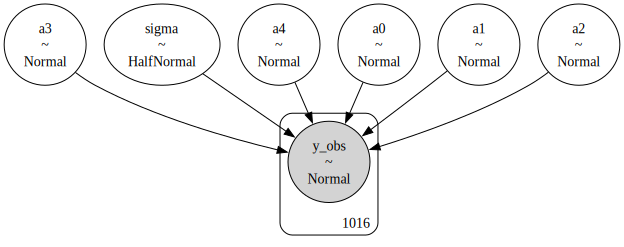

In [71]:
model_ocx.to_graphviz()

In [72]:
with model_ocx:
    idata_ocx = pm.sample_prior_predictive()
    idata_ocx.extend(pm.sample())
    idata_ocx.extend(pm.sample_posterior_predictive(idata_ocx))

Sampling: [a0, a1, a2, a3, a4, sigma, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, a1, a2, a3, a4, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: [y_obs]


Output()

In [74]:
with model_ocx:
    ll_ocx = pm.compute_log_likelihood(idata_ocx)

Output()

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


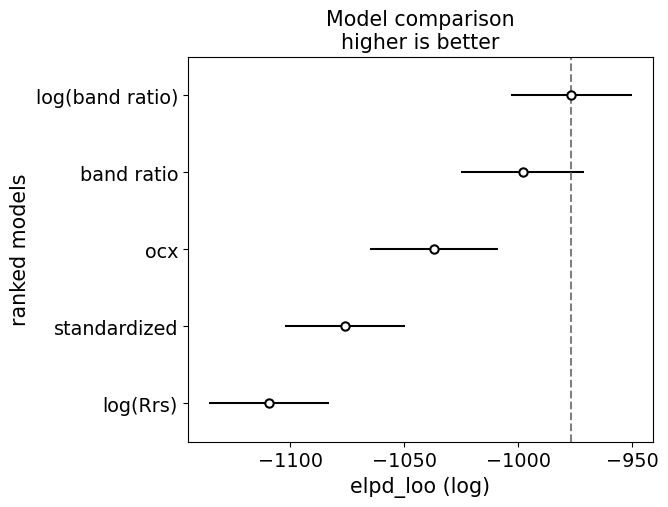

In [ ]:
compare_results = az.compare(
    {
        'standardized' :ll_tm1, 'log(Rrs)':ll_tm2, 'band ratio':ll_tm3, 'log(band ratio)': ll_tm4,
        'ocx': ll_ocx
        }, ic='loo'
)
ax = az.plot_compare(compare_results, )
fc = pp.gcf()

In [77]:
# Compute the CI value using Hu et al.'s formulation:
# CI = Rrs(555) - [ Rrs(443) + (555-443)/(670-443) * (Rrs(670) - Rrs(443)) ]
df_ci = dx.copy()
weight = (555 - 443) / (670 - 443)
df_ci['CI'] = df_ci['rrs555'] - (df_ci['rrs443'] + weight * (df_ci['rrs670'] - df_ci['rrs443']))

# (Optional) Inspect the computed CI and logChl values
print(df_ci.head())

         rrs411    rrs443    rrs489    rrs510    rrs555    rrs670        CI
index                                                                      
0      0.001204  0.001686  0.003293  0.004036  0.007479  0.003465  0.004916
1      0.001062  0.001384  0.002173  0.002499  0.004152  0.001695  0.002615
2      0.000971  0.001185  0.001843  0.002288  0.004246  0.001612  0.002850
3      0.001472  0.001741  0.002877  0.003664  0.006982  0.003234  0.004504
4      0.000905  0.001022  0.001506  0.001903  0.002801  0.001791  0.001399


In [78]:
with pm.Model() as model_ci:
    # Priors for the regression coefficients
    a = pm.Normal("a", mu=0, sigma=10)
    b = pm.Normal("b", mu=0, sigma=10)
    
    # Expected log(chlorophyll) as a linear function of CI
    mu = a + b * df_ci["CI"].values
    
    # Likelihood: assume normally distributed errors
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=log_dy)

In [79]:
with model_ci:
    idata_ci = pm.sample_prior_predictive()
    idata_ci.extend(pm.sample())
    idata_ci.extend(pm.sample_posterior_predictive(idata_ci))


Sampling: [a, b, sigma, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y_obs]


Output()

In [80]:
with model_ci:
    ll_ci = pm.compute_log_likelihood(idata_ci)

Output()

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


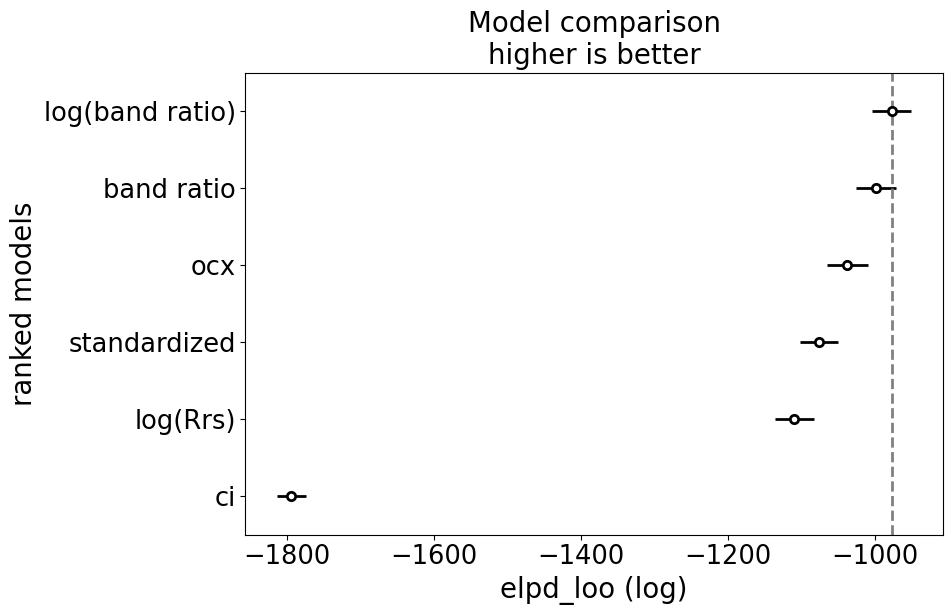

In [82]:
compare_results = az.compare(
    {
        'standardized' :ll_tm1, 'log(Rrs)':ll_tm2, 'band ratio':ll_tm3, 'log(band ratio)': ll_tm4,
        'ocx': ll_ocx, 'ci': ll_ci
        }, ic='loo'
)
ax = az.plot_compare(compare_results, figsize=(9, 6))
fc = pp.gcf()